In [4]:
import ipympl
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from datetime import datetime
import glob, os
from time import time

In [6]:
env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)
start_time = int(time())
writer = SummaryWriter(f'logs/deep_pytorch/{start_time}')

Furthest Position: -0.10450220672068848


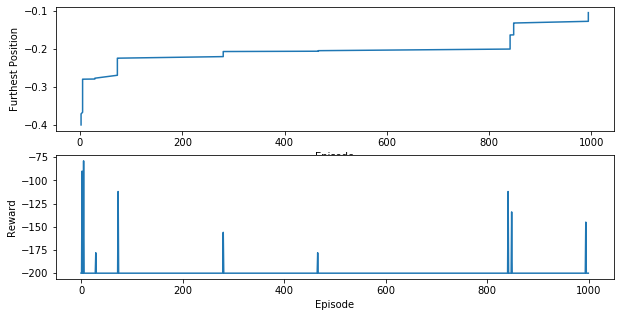

successful episodes: 0


In [9]:
max_position = -.4
positions = np.ndarray([0,2])
rewards = []
successful = []
for episode in range(1000):
    running_reward = 0
    env.reset()
    done = False
    for i in range(200):
        state, reward, done, _ = env.step(np.random.randint(0,3))
        # Give a reward for reaching a new maximum position
        if state[0] > max_position:
            max_position = state[0]
            positions = np.append(positions, [[episode, max_position]], axis=0)
            running_reward += 10
        else:
            running_reward += reward
        if done: 
            if state[0] >= 0.5:
                successful.append(episode)
            rewards.append(running_reward)
            break

print('Furthest Position: {}'.format(max_position))
plt.figure(1, figsize=[10,5])
plt.subplot(211)
plt.plot(positions[:,0], positions[:,1])
plt.xlabel('Episode')
plt.ylabel('Furthest Position')
plt.subplot(212)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('successful episodes: {}'.format(np.count_nonzero(successful)))

In [11]:
# I tried different weight initializations but found they did not perform well.

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)

In [12]:
# Parameters
steps = 200
state = env.reset()
epsilon = 0.3
gamma = 0.99
loss_history = []
reward_history = []
episodes = 1000
max_position = -0.4
learning_rate = 0.001
successes = 0
position = []

# Initialize Policy
policy = Policy()
#policy.apply(weights_init)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()

    for s in range(steps):
        # Uncomment to render environment
        #if episode % 100 == 0 and episode > 0:
        #    env.render()
        
        # Get first action value function
        Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # Step forward and receive next state and reward
        state_1, reward, done, _ = env.step(action)
        
        # Adjust reward based on car position
        reward = state_1[0] + 0.5
        
        # Keep track of max position
        if state_1[0] > max_position:
            max_position = state_1[0]
            writer.add_scalar('data/max_position', max_position, episode)
        
        # Adjust reward for task completion
        if state_1[0] >= 0.5:
            reward += 1
        
        # Find max Q for t+1 state
        Q1 = policy(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
        maxQ1, _ = torch.max(Q1, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target)
        Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy
        policy.zero_grad()
        loss.backward()
        optimizer.step()

        episode_loss += loss.item()
        episode_reward += reward
        
        if done:
            if state_1[0] >= 0.5:
                # On successful epsisodes, adjust the following parameters

                # Adjust epsilon
                epsilon *= .95
                writer.add_scalar('data/epsilon', epsilon, episode)

                # Adjust learning rate
                scheduler.step()
                #optimizer.param_groups[0]['lr'] = max(optimizer.param_groups[0]['lr'], 1.0e-4)
                writer.add_scalar('data/learning_rate', optimizer.param_groups[0]['lr'], episode)

                # Record successful episode
                successes += 1
                writer.add_scalar('data/cumulative_success', successes, episode)
                writer.add_scalar('data/success', 1, episode)
            
            elif state_1[0] < 0.5:
                writer.add_scalar('data/success', 0, episode)
            
            # Record history
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)
            writer.add_scalar('data/episode_loss', episode_loss, episode)
            writer.add_scalar('data/episode_reward', episode_reward, episode)
            weights = np.sum(np.abs(policy.l2.weight.data.numpy()))+np.sum(np.abs(policy.l1.weight.data.numpy()))
            writer.add_scalar('data/weights', weights, episode)
            writer.add_scalar('data/position', state_1[0], episode)
            position.append(state_1[0])

            break
        else:
            state = state_1
            
writer.close()
print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

100%|██████████| 1000/1000 [01:15<00:00, 14.98it/s]

successful episodes: 628 - 62.8000%


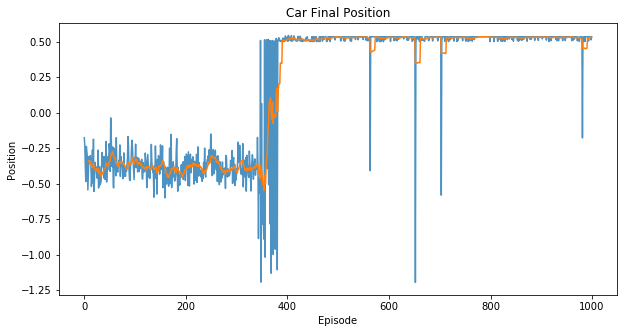

In [13]:
plt.figure(2, figsize=[10,5])
p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.savefig('Final Position - Modified.png')
plt.show()